# PREPARATION

## IMPORTS

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

In [39]:
# Prevent CUDA from allowing all GPU memory, to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## PARAMETERS DEFINITION

In [40]:
DATA_PATH = "images"
ROOT_PATH = '/home/guillaume/code/35m5loKiUe/WGAN_DATA/'
MODEL_PATH = 'model_saves'
GIF_PATH = 'gif_pics'

NB_FILTERS = 256
IMAGE_SIZE = 64
BUFFER_SIZE = 60000
BATCH_SIZE = 128
NB_CONVOL_GEN = 3
NB_CONVOL_DISC = 3
NOISE_DIM = 100
EPOCHS = 100
MODEL_SAVE_FRQ = 5

## DATASET LOADING

In [41]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT_PATH, DATA_PATH),
    label_mode=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
)
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
train_dataset = train_dataset.map(lambda x: (normalization_layer(x)))

Found 25663 files belonging to 1 classes.


# MODEL DEFINITION

## GENERATOR

In [42]:
def get_generator_model(IMAGE_SIZE, NB_FILTERS, NB_CONVOL_GEN):
    model = tf.keras.Sequential()
    
    init_img_size = int((IMAGE_SIZE / 2**NB_CONVOL_GEN))
        
    # Dense layer to get sufficient dimensions to create 1st convolution
    model.add(layers.Dense(init_img_size * init_img_size * NB_FILTERS, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Reshape for 1st convolution
    model.add(layers.Reshape((init_img_size, init_img_size, NB_FILTERS)))
    
    #Transpose convolution layers
    for i in range(1, NB_CONVOL_GEN+1):      
        model.add(layers.Conv2DTranspose(NB_FILTERS/2**i, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
    
    #Last convolution layer to return
    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation=None))
    model.add(layers.Activation('tanh'))

    return model

In [43]:
generator = get_generator_model(IMAGE_SIZE, NB_FILTERS, NB_CONVOL_GEN)

## DISCRIMIATOR

In [44]:
def get_discriminator_model(NB_CONVOL_DISC):
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #Transpose convolution layers
    for i in range(0, NB_CONVOL_DISC):      
        model.add(layers.Conv2D(NB_FILTERS/2**i, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
      
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [45]:
discriminator = get_discriminator_model(NB_CONVOL_DISC)

## WGAN MODEL

In [46]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal(
            [batch_size, 1, 1, 1],
            mean=0.0,
            stddev=1.0
        )
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

# MONITORING

In [47]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, sqr_size=5, latent_dim=128):
        self.sqr_size = sqr_size
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.sqr_size**2, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        
        if not epoch%MODEL_SAVE_FRQ :
            self.model.generator.save(os.path.join(ROOT_PATH, MODEL_PATH, 'generator_after_epoch_{epoch}').format(epoch=epoch))
            self.model.discriminator.save(os.path.join(ROOT_PATH, MODEL_PATH, 'discriminator_after_epoch_{epoch}').format(epoch=epoch))
        
        
        fig = plt.figure(figsize=(10, 10))
        for i in range(generated_images.shape[0]):
            plt.subplot(self.sqr_size, self.sqr_size, i+1)
            plt.imshow((generated_images[i, :, :, :]+1)*127.5)
            plt.axis('off')
        plt.savefig(os.path.join(ROOT_PATH, GIF_PATH,'image_at_epoch_{:04d}.png').format(epoch))
        plt.show()    
        
        #for i in range(self.num_img):
        #    img = generated_images[i].numpy()
        #    img = keras.preprocessing.image.array_to_img(img)
        #    img.save(os.path.join(ROOT_PATH, GIF_PATH, "generated_img_{i}_{epoch}.png").format(i=i, epoch=epoch))

# INSTANCIATION

## OPTIMIZER

In [48]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

## LOSSES FUNCTIONS

In [49]:
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

## MONITOR

In [50]:

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(sqr_size=5, latent_dim=NOISE_DIM)

## MODEL

In [51]:
# Get the wgan model
wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=NOISE_DIM,
    discriminator_extra_steps=3,
)



In [52]:
# Compile the wga}n model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# TRAIN

Epoch 1/100


2023-02-16 19:14:28.503620: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_4/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - ETA: 0s - d_loss: -20.2454 - g_loss: 23.5661WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /home/guillaume/code/35m5loKiUe/WGAN_DATA/model_saves/generator_after_epoch_0/assets


INFO:tensorflow:Assets written to: /home/guillaume/code/35m5loKiUe/WGAN_DATA/model_saves/generator_after_epoch_0/assets


INFO:tensorflow:Assets written to: /home/guillaume/code/35m5loKiUe/WGAN_DATA/model_saves/discriminator_after_epoch_0/assets


INFO:tensorflow:Assets written to: /home/guillaume/code/35m5loKiUe/WGAN_DATA/model_saves/discriminator_after_epoch_0/assets


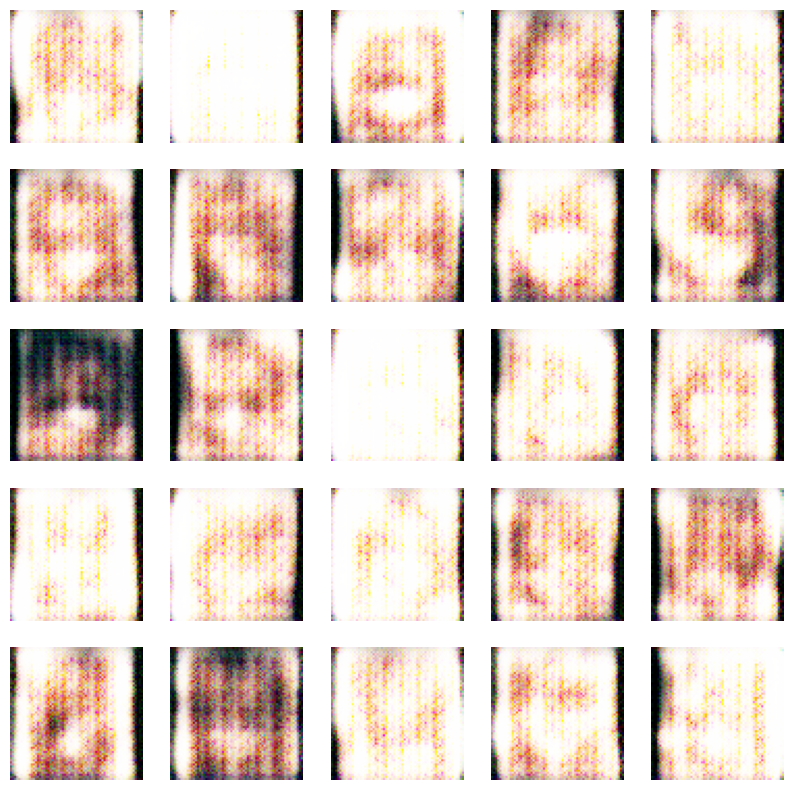

201/201 [==============================] - 97s 440ms/step - d_loss: -20.1703 - g_loss: 23.5575
Epoch 2/100
201/201 [==============================] - ETA: 0s - d_loss: -6.1197 - g_loss: 4.1613

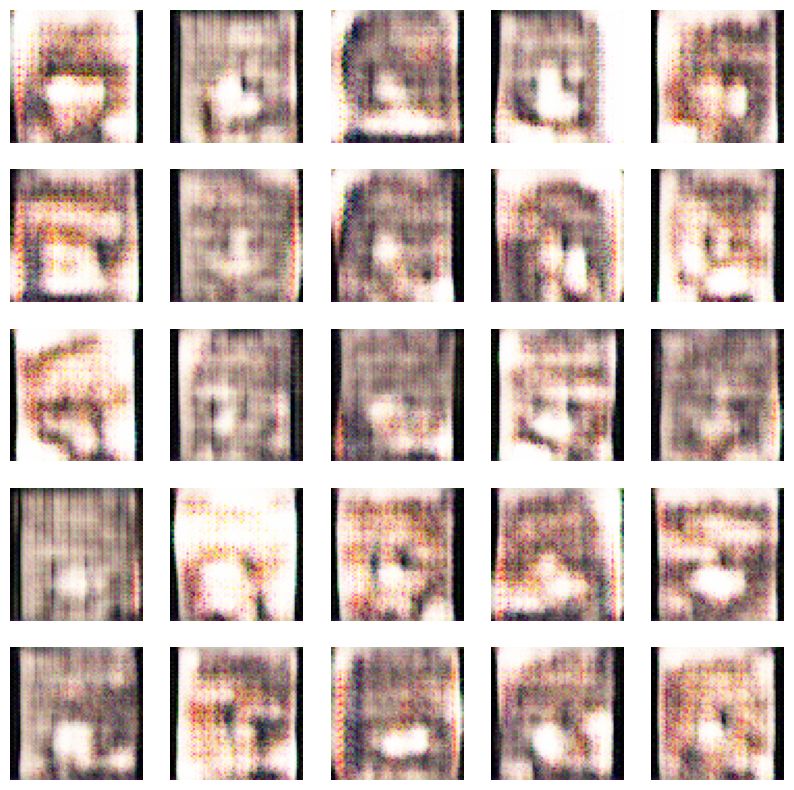

201/201 [==============================] - 85s 421ms/step - d_loss: -6.1232 - g_loss: 4.0672
Epoch 3/100
201/201 [==============================] - ETA: 0s - d_loss: -5.3609 - g_loss: 6.7994

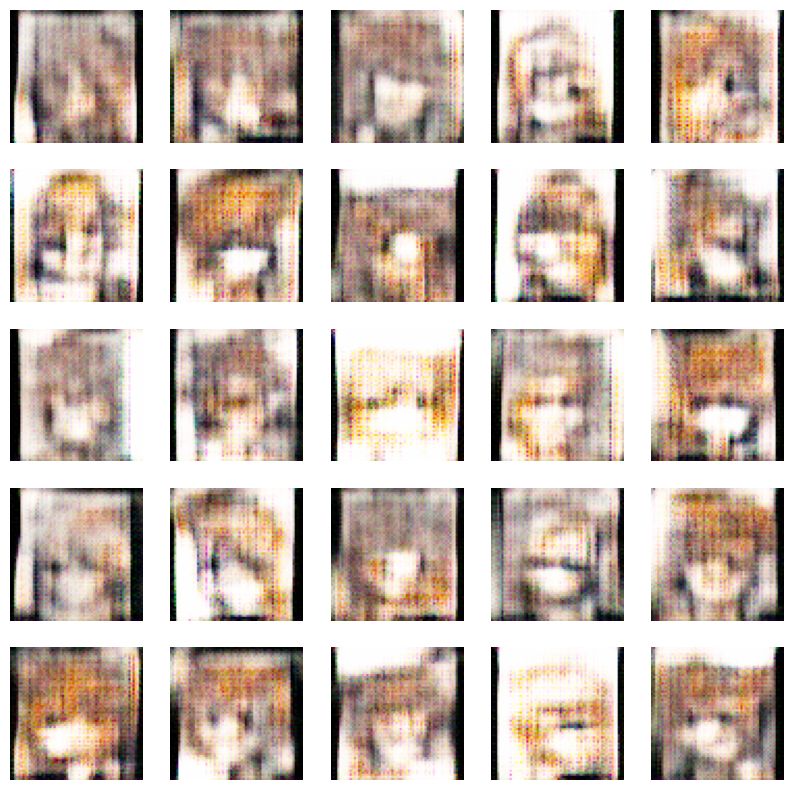

201/201 [==============================] - 85s 419ms/step - d_loss: -5.3586 - g_loss: 6.8385
Epoch 4/100
201/201 [==============================] - ETA: 0s - d_loss: -4.7119 - g_loss: 2.2680

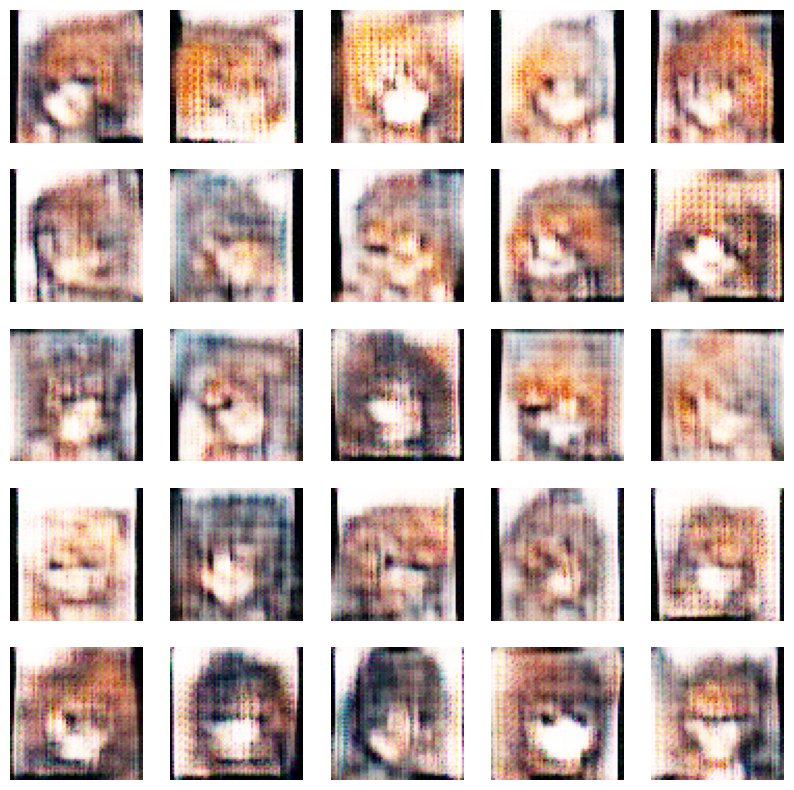

201/201 [==============================] - 86s 423ms/step - d_loss: -4.7111 - g_loss: 2.2280
Epoch 5/100
201/201 [==============================] - ETA: 0s - d_loss: -4.0142 - g_loss: 1.6983

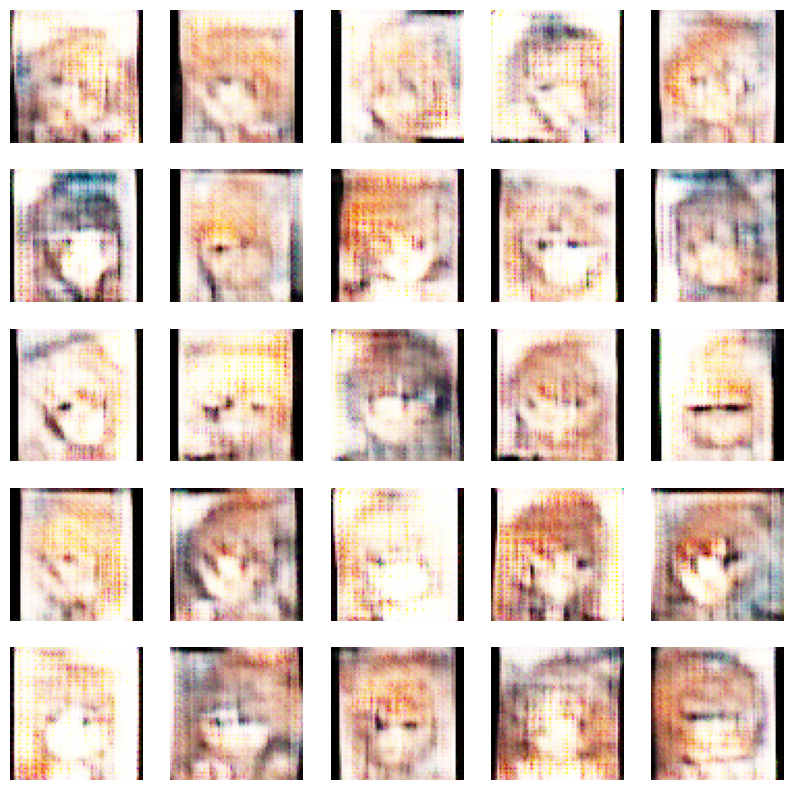

201/201 [==============================] - 86s 424ms/step - d_loss: -4.0131 - g_loss: 1.7186
Epoch 6/100
 26/201 [==>...........................] - ETA: 1:12 - d_loss: -4.1486 - g_loss: 9.9354

KeyboardInterrupt: 

In [37]:
# Start training
wgan.fit(train_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[cbk])

In [35]:
epoch = 60
generator = keras.models.load_model(os.path.join(ROOT_PATH, MODEL_PATH, 'generator_after_epoch_{epoch}').format(epoch=epoch))
generator = keras.models.load_model(os.path.join(ROOT_PATH, MODEL_PATH, 'discriminator_after_epoch_{epoch}').format(epoch=epoch))